In [1]:
import torch as t
import numpy as np
import time 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from mpl_toolkits.mplot3d import axes3d
import os
import shutil
#from pyntcloud import PyntCloud
import open3d as o3d

In [2]:
if t.cuda.is_available():
    device = "cuda"
else: 
    device = "cpu"
print(device)

cuda


In [3]:
def ntime(s):
    m = 15
    l = [(s/m**2)%24, (s/m)%m, (s)%m]
    return([int(x) for x in l])
def coco(tl, ni, pt):
    sm = sum(tl)
    tt = 10*(pt)
    if sm > tt: 
        l = tuple(ntime(np.mean(tl)*ni-sum(tl)))
    else: 
        return([pt,'',''])
    if sm > tt and pt%15 != 14:
        return([pt+1,str("%02d:%02d:%02d," % l),''])
    elif sm > tt and pt%15 == 14:
        return([pt+1,str("%02d:%02d:%02d," % l),'\n'])

# NN architecture

In [4]:
class DNet(t.nn.Module):
    def __init__(self):
        super().__init__()
        C_in = 1
        self.linear1 = t.nn.Linear(sz**dm*C_in, layers[0])
        self.linear2 = t.nn.Linear(layers[0],layers[1])
        self.linear3 = t.nn.Linear(layers[1],layers[2])
        self.linear4 = t.nn.Linear(layers[2], k)
        self.do = t.nn.Dropout(p=dop)
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.do(F.leaky_relu(self.linear1(x).clamp(min=0)))
        x = self.do(F.leaky_relu(self.linear2(x)))
        x = self.do(F.relu(self.linear3(x)))
        x = self.do(self.linear4(x))
        return x

In [5]:
nnarchitectures = { 'DNet' : DNet}

# Ellipse generator

## Figure initialization 

In [6]:
def figure2D_init():
    X, Y = [t.arange(0, sz, 1, dtype=t.float32, requires_grad=True)]*2
    X, Y = t.meshgrid(X, Y)
    X, Y = X.to(device), Y.to(device)
    return(X, Y)
def figure3D_init():
    X, Y, Z = [t.arange(0, sz, 1, dtype=t.float32, requires_grad=True)]*3
    X, Y, Z = t.meshgrid(X, Y, Z)
    X, Y, Z = X.to(device), Y.to(device), Z.to(device)
    return(X, Y, Z)
def smoothborder(r, x):
    if len(x) == 4:
        r0 = t.sqrt(x[2]**2+x[3]**2)
        r0 = r0.to(device)
    elif len(x) == 3:
        r0 = x[2]
    I = (r <= r0)
    a = 1
    c = 4
    if gs == 1:
        I2 = (1+a*np.exp(c))/(1+a*t.exp(c*r/r0))
        I = I + (r > r0) * I2
    return(I)

## figures generator

In [7]:

def ellipses(x):
    I, R = [t.zeros([sz]*dm, dtype=t.float32, requires_grad=True)]*2
    I, R = I.to(device), R.to(device)
    for i in range(int(len(x)/k)): 
        if dm == 2: 
            X, Y = figure2D_init()
        if dm == 2 and k == 3:
            r = t.sqrt(((X-x[k*i]*sz)**2 + (Y-x[k*i+1]*sz)**2))/sz
            r = r.to(device)
            I = I + smoothborder(r, x[k*i:k*(i+1)])
            R = (I>=1) + (I<1)*I # delete overlaption, that maximum intensity is 1, but that is less than one remains the same
        elif dm == 2 and k == 4:
            r = t.sqrt((((X-x[k*i]*sz)/x[k*i+2])**2 + ((Y-x[k*i+1]*sz)/x[k*i+3])**2))/sz
            r = r.to(device)
            I = I + smoothborder(r, x[k*i:k*(i+1)], gs)
            R = (I>=1) + (I<1)*I # delete overlaption, that maximum intensity is 1, but that is less than one remains the same
        if dm == 3:
            X, Y, Z = figure3D_init()
        if dm == 3 and k == 4:
            r = t.sqrt((X-x[k*i]*sz)**2 + (Y-x[k*i+1]*sz)**2 + (Z-x[k*i+2]*sz)**2)/sz
            R = (r<=x[k*i+3])
        elif dm == 3 and k == 6:
            r = t.sqrt(((X-x[k*i+0]*sz)/x[k*i+3])**2+\
              ((Y-x[k*i+1]*sz)/x[k*i+4])**2+\
              ((Z-x[k*i+2]*sz)/x[k*i+5])**2)/sz
            R = (r<=t.sqrt((x[k*i+3])**2+(x[k*i+3])**2+(x[k*i+4])**2)) 
    #print(R.shape)
    return(R)
#def genbatch(label, k, dm, sz, bs, n, device, randinit, gs):


## Batch generator

In [8]:
def genbatch(label):
    cbs = label.shape[0]
    if dm == 2 and randinit:
        data = t.rand([cbs,1,sz,sz])
    elif dm == 2 and not(randinit):
        data = t.zeros([cbs,1,sz,sz], dtype=t.float32)
    elif dm == 3 and randinit:
        data = t.rand([cbs,1,sz,sz,sz])
    elif dm == 3 and not(randinit):
        data = t.zeros([cbs,1,sz,sz,sz], dtype=t.float32)
    data = data.to(device)
    if not(randinit):
        for i in range(cbs):
            data[i] = ellipses(label[i,:])
    return(data.float())

# Neural network training

In [9]:
np.random.seed(0)
t.random.manual_seed(0)

In [10]:
def multit():
    starta = time.time()
#     model = None
#     if model is None:
    model = nnarchitectures[modelname]()
    model.to(device)
    #model = model.double()
    optimizer = t.optim.Adam(model.parameters(), lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    tl = []
    pt = 0
    lossa = np.zeros([2, epochs])
    ytest, yval, labelstrain = labels[0], labels[1], labels[2:]
    xtest, xval = genbatch(ytest), genbatch(yval)
    for j in range(epochs):
        start = time.time()  
        for i in range(bn-2):
            #data = idata[i]
            ytrain = labelstrain[i]
            xtrain = genbatch(ytrain)
            #xtrain, xval, ytrain, yval = [data[i] for i in range(4)]
#             for i in range(4): 
#                 print(data[i].shape)
            #, data[1], data[2], data[3] #first counter is batch counter, second is data counter
            loss = []
            criterion = t.nn.MSELoss(reduction='mean')
            #start = time.time()
            #print(tm)
            xtrain = xtrain.detach() #xtrain contains images of the circle
            #print(xtrain.shape)
            #print(ytrain.shape)
            #print(model.dtype)
            #print(xtrain.shape)
            y_pred = model(xtrain) #y_pred consists of coordinates of the circle center and its radius
            
            if ltype == 'supervised': 
                # Forward pass: Compute predicted y by passing x to the model
                #calculating loss between predicted parameters and parameters which were used for generation
                loss = criterion(y_pred, ytrain)
            else: 
                x_pred = t.zeros([N,1,sz,sz])
                for i in range(N):
                    # Generating circles with inferred parameters y_pred.
                    #print(y_pred)
                    x_pred[i,0,:,:] = ellipses(y_pred, k, sz, device)
                # Compute and print loss
                # Compare generated image with the input image, finding per-pixel distance between two images
                loss = criterion(x_pred, xtrain)
                #print(loss.item())
            #print('trainig loss counter', i+j*bn)
            #lossa[0][i+j*bn] = loss.item() #the first number in the loss is a training loss
            #updating list with losses 
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #lossc = lossa
            #lossa[1][i+j*bn] = criterion(model(xval), yval).item() #the second number in the loss is a validation loss
            #print(i+j*bn)
#             end = time.time()
#             tl.append(end-start)
#             ntime(sum(tl) / len(tl)*bn - sum(tl))
        lossa[0][j] = loss.item()
        lossa[1][j] = criterion(model(xval), yval).item()
        end = time.time()
        tl.append(end-start)
        col = coco(tl,epochs,pt)
        pt = col[0]
        print(col[1], end = col[2])
    enda = time.time()
    timelapse = enda - starta
    return(model, lossa, timelapse)

In [44]:
lossb = [lossa, lossa]

In [101]:
print(lossb[0][0].shape[0])

100


In [60]:
labels_text[1][1]

'validation rand input'

In [108]:
def traplot():
    ymin, ymax = -8, -1
    plt.rcParams["figure.figsize"] = (18,10)
    linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':']
    colors = ['red', 'green']
    axes = plt.gca()
    labels_text = [['train', 'validation'], ['train rand input', 'validation rand input']]
    axes.set_ylim([ymin,ymax])
    for trt in range(2):
        for isr in range(2):
            plt.plot(np.arange(lossa.shape[1]), np.log(lossb[isr][trt][:]), label=labels_text[trt][isr], \
                     color = colors[isr], linestyle=linestyles[trt], linewidth=3)
    axes.set_xticks(np.arange(0, int(lossb[0][0].shape[0]*1.1), int(lossb[0][0].shape[0]*0.1)))
    axes.set_yticks(np.arange(ymin, ymax, 1))
    plt.grid()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0., fontsize = 24)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.autoscale(enable=True, axis='both', tight=None)
    plt.xlabel('Epoch', fontsize=24)
    plt.ylabel('log(MSE Loss)', fontsize=24)
    plt.savefig('k'+str(k)+'_'+'n'+str(n)+'_'+'sz'+str(sz)+'_'+'bn'+str(bn)+','+'bs'+str(bs)+'_'+\
                'epochs'+str(epochs)+'_'+'layers'+str(layers)+'_'+'lr'+str(lr)+'_'+'etime'+\
                format(timelapse,".2f") + '_' + 'noisein' + str(randinit) +'.png', bbox_inches='tight')
    plt.show()

In [104]:
np.arange(0, 100, 10)

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

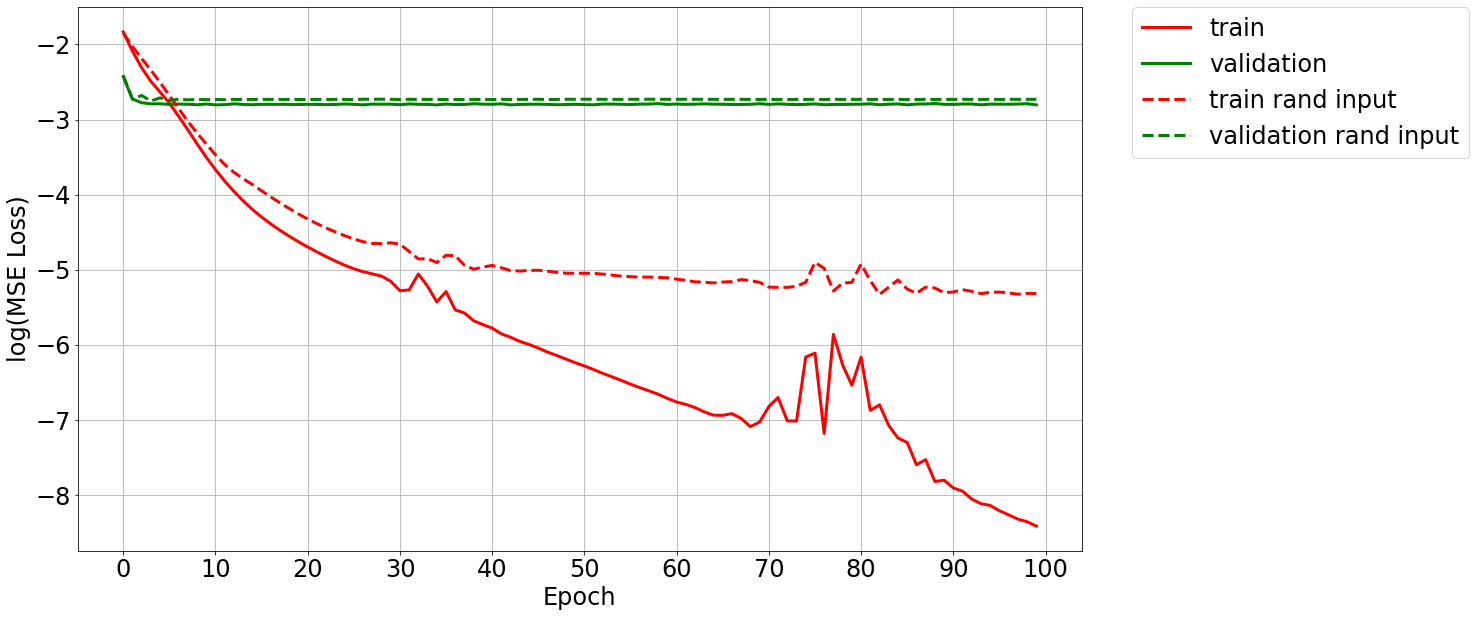

In [109]:
traplot()

In [50]:
labels_text = [['train', 'validation'], ['train rand input', 'validation rand input']]
print(labels_text[1][1])

validation rand input


In [51]:
np.log(lossa[trt][:])

NameError: name 'trt' is not defined

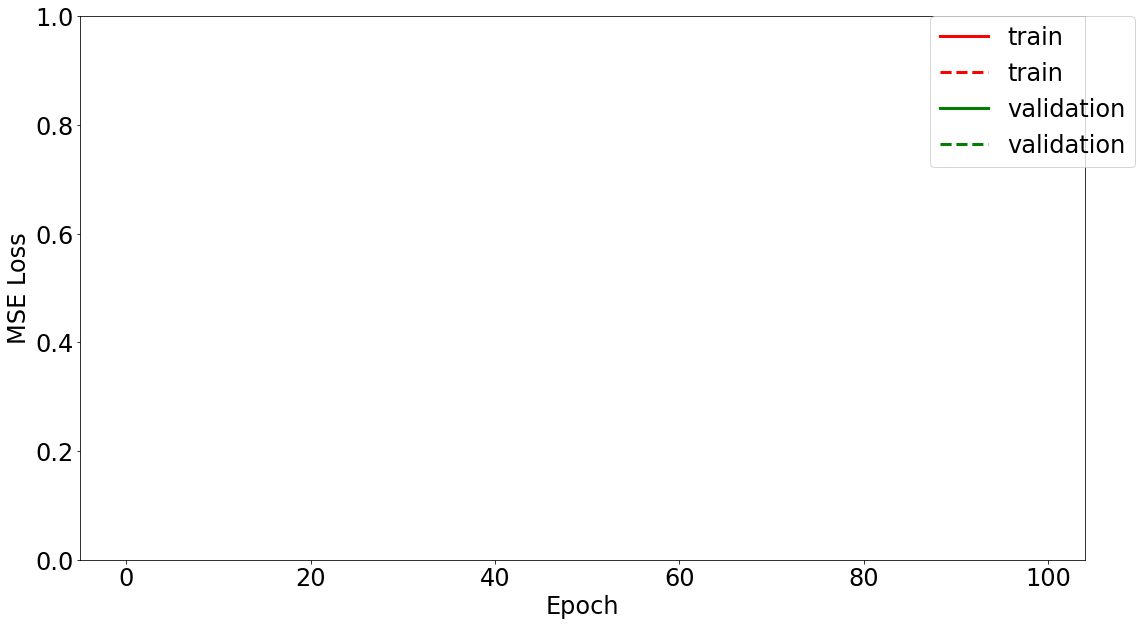

In [14]:
def ft2k():
    if ft == 'circle':
        k, dm, rn = 3, 2, 1
    elif ft == 'ellipse': 
        k, dm, rn = 4, 2, 2
    elif ft == 'tilted ellipse': 
        k, dm, rn = 5, 2, 2
    elif ft == 'sphere':
        k, dm, rn = 4, 3, 1
    elif ft == 'ellipsoid':
        k, dm, rn = 6, 3, 3
    elif ft == 'tilted ellipsoid':
        k, dm, rn = 7, 3, 3
    return(k, dm, rn)

In [15]:
def labelset():
    if ovl == 1: 
        labels = np.random.rand(bn,bs,k*n).astype('f')
    else:
        labels = np.zeros([bn,bs,k*n]).astype('f')
        for i in range(bn):
            for j in range(bs):
                for l in range(n):
                    labels[i][j][l:l+k-rn] = np.random.rand(k-rn).astype('f')
                    if rn > 1:
                        for ax in range(rn):
                            m = min(labels[i][j][l+ax], 1-labels[i][j][l+ax])
                            labels[i][j][l+k-rn+ax] = (5/sz - m) * np.random.rand(1).astype('f') + m
                    else:
                        m = min(np.concatenate((labels[i][j][l:l+k-rn], 1-labels[i][j][l:l+k-rn]), axis=0))
                        labels[i][j][l+k-1] = (5/sz - m) * np.random.rand(1).astype('f') + m
    return(labels)

In [16]:
epochs = 100 #how many epochs 
lr = 5e-5 #learning rate
sz = 100 #image resolution
bn = 10 #how many batches
bs = 100 #how many images in a batch
ft = 'circle' #circle 3, ellipse 4, sphere 4, ellipsoid 6, angled ellipse 5, angled ellipsoid 7 
k, dm, rn = ft2k()
n = 1 #number of objects per image 
layers = [1000, 500, 200] #number of neurons at every layer
dop = 0 #drop out percentage 0 to 1. 
randinit = 0 #0 is ellipse generator, 1 is noise generator
gs = 1 #Gauss smoothing 
modelname = 'DNet'
ltype = 'supervised'
ovl = 0
#labels = labelset(bn, bs, k, n, ovl, rn)
labels = labelset()
#print(labels.shape)
labels = t.tensor(labels).to(device)
label = labels[0]
lossb = np.zeros([2, 2, epochs])

#labels.shape

In [17]:
yval = labels[1]
ytest = labels[0]
ytrain = labels[2:]
print(yval.shape, ytest.shape, ytrain.shape)

torch.Size([100, 3]) torch.Size([100, 3]) torch.Size([8, 100, 3])


In [18]:
label.dtype

torch.float32

In [106]:
randinit = 0
model, lossb[0], timelapse = multit()
randinit = 1
model, lossb[1], timelapse = multit()

00:06:07,00:06:02,00:05:07,00:04:14,00:04:04,00:03:09,00:02:13,00:02:03,00:01:07,00:00:12,00:00:02,00:00:06,

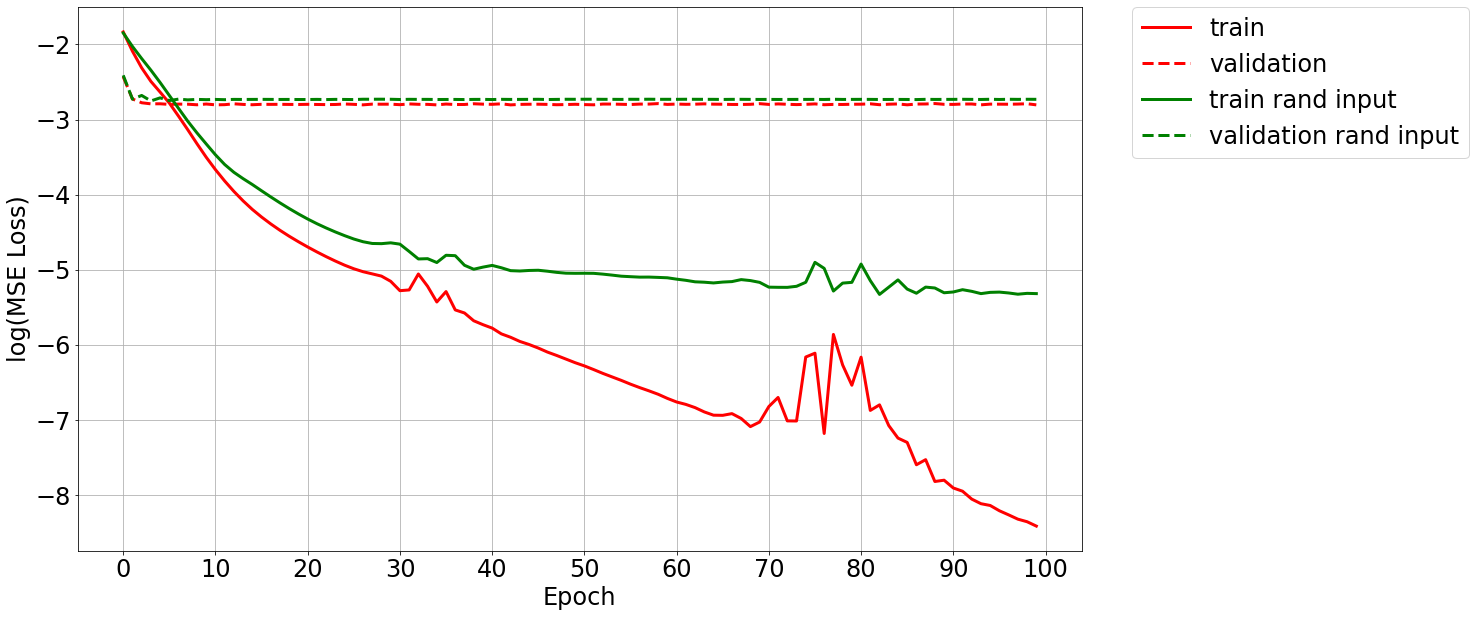

In [107]:
traplot()

In [ ]:
xval = idata[0]
yval = labels[i][0]

In [ ]:
print(lossa[0])

In [ ]:
#data = genbatch(labels[0], k, dm, sz, bs, n, device, randinit, gs)
datac = genbatch()

### 2D plot of input and output images

In [49]:
#print(labels[1].shape)
inar = np.squeeze(genbatch(labels[0][:5]).detach().cpu().numpy())
#print(array.shape, array.dtype)
outar = np.squeeze(genbatch(model(genbatch(labels[0][:5]))).detach().cpu().numpy())
print(inar.shape)
print(outar.shape)

(5, 100, 100)
(5, 100, 100)


In [94]:
print(labels[1][:5])

tensor([[0.9683, 0.3513, 0.0455],
        [0.8818, 0.6274, 0.0719],
        [0.4131, 0.4831, 0.2024],
        [0.2157, 0.0559, 0.0555],
        [0.9434, 0.5964, 0.0566]], device='cuda:0')


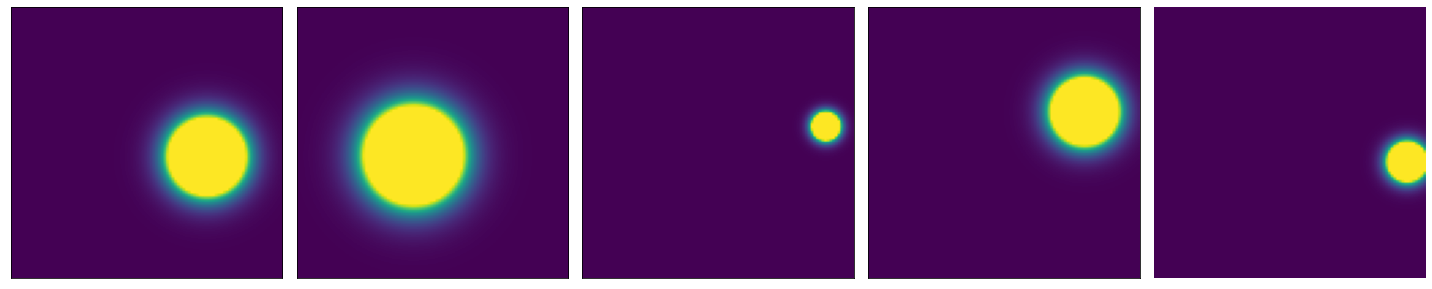

In [58]:
plt.rcParams["figure.figsize"] = (20,10)
nrows=1
ncols=5
figure, ax = plt.subplots(nrows, ncols)
for i in range(nrows*ncols):
    #print(np.unravel_index(i, (nrows,ncols)))
    axe = ax[i]
    #axe = ax[np.unravel_index(i, (nrows,ncols))]
    axe.imshow(inar[i])  
    axe.set_xticks([])
    axe.set_yticks([])
plt.axis('off')
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
figure.tight_layout()
plt.savefig((r'C:\Users\v.cherepashkin\Documents\GitHub\circles\plot output\input_data'+str(time.time())+'.png').replace('\\', '/'))

### 3D plot

In [ ]:
plt.rcParams["figure.figsize"] = (18,10)
nrows, ncols =1,4
fig = plt.figure()
for i in range(nrows*ncols):
        ax = fig.add_subplot(int(str(nrows)+str(ncols)+str(i+1)), projection='3d') 
        ax.voxels(datac[i+3][0])
        plt.axis('off')
        plt.autoscale(enable=True, axis='both', tight=None)
#dt = str(datetime.fromtimestamp(int(time.time())))
plt.savefig(os.getcwd() + '\plot output'+'\k'+str(k)+'_'+'n'+str(n)+'_'+'sz'+str(sz) +\
            'time' + time.strftime("%H%M%S") + '.png', bbox_inches='tight')

In [ ]:
#cloud = PyntCloud.from_file("sample.ply")
#cloud = PyntCloud.from_file("1491988_Surface.ply")
#new_cloud = cloud.get_sample("voxelgrid_nearest", voxelgrid_id=datac[i+3][0], as_PyntCloud=True)

In [ ]:
# from open3d import *    
# import open3d

def main():
    cloud = o3d.io.read_point_cloud("1491988_Surface.ply") # Read the point cloud
    #cloud = o3d.io.read_point_cloud("1491988_Surface.ply") # Read the point cloud
    o3d.visualization.draw_geometries([cloud]) # Visualize the point cloud     

if __name__ == "__main__":
    main()

In [ ]:
cloud = o3d.io.read_point_cloud("1492214_Surface.ply") # Read the point cloud
    #cloud = o3d.io.read_point_cloud("1491988_Surface.ply") # Read the point cloud
o3d.visualization.draw_geometries([cloud]) # Visualize the point cloud     

In [ ]:
traplot(lossa[0], lossa[1]) 

In [ ]:
timelapse = lossa[1]
lossa = lossa[0]
traplot()